# Yelp Data Challenge - NLP

Here I will build sentiment analysis models to classify reviews into positive/negative categories. Such models are useful in identifying points of concern, especially when it's infeasible to comb through reviews manually. 

For this project, I will simulate encountering new data with a heldout test set.

## Imports

In [1]:
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# nltk.download('stopwords')
plt.style.use("ggplot")

%load_ext autoreload
%autoreload 1
%aimport src.nlp_helpers
from src.nlp_helpers import get_top_values, get_bottom_values, get_n_most_frequent_tokens

## Load data
We will use the DataFrame constructed in `Data_Preprocessing.ipynb`. It contains reviews of restaurants from Las Vegas from approximately the last 2 years.

In [2]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv',
                 dtype={tag: np.int16 for tag in ("useful", "funny", "cool")})

df = df.drop(columns=["attributes"])

In [3]:
# Minor number of NAs in 'attributes'; fortunately, we won't need that feature
pd.DataFrame.sum(df.isna())

business_id    0
name           0
categories     0
avg_stars      0
review_id      0
user_id        0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

### Define review data set

What constitutes a "positive" review? A sensible baseline is to equate that with 5-star reviews, the highest rating possible. After all, any rating below the highest possible may indicate room for improvement, on the restaurant's part.

In [4]:
raw_reviews = df.text
target = df.stars.apply(lambda s: s == 5)

target.value_counts()  # class label almost balanced

False    61094
True     54700
Name: stars, dtype: int64

There are 115794 reviews in total.

Sample: I was quite fortunate to have discovered this nice little Thai restaurant near work! Their food is quite exceptional and beyond the many great eateries we r bless with in this great city of our. The thing I like most about this particular Thai restaurant is the in-house made curry and the friendly service from the staff! Eventhough I m not a really  big fan of spicy food! The curry has enough special herbs to balance out the flavor! I will definitely be back for my lunch break at this little desert flower!


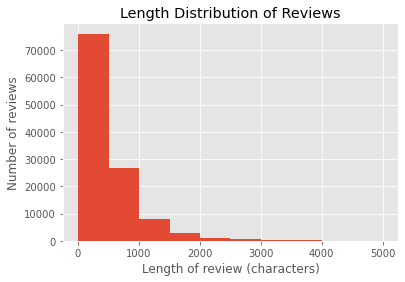

In [5]:
"""
    Inspect documents: check length and display an example.
    
    Reviews come in various lengths; deep learning especially RNN models
    may work well but it may also be an overkill. (Padding reviews to the
    same length also consumes a lot of RAM.). Will adopt bag-of-words 
    approach.
"""

plt.hist(raw_reviews.apply(len))
plt.title("Length Distribution of Reviews")
plt.ylabel("Number of reviews")
plt.xlabel("Length of review (characters)")

print("There are {} reviews in total.".format(len(raw_reviews)))
print("\nSample: {}".format(raw_reviews[0]))

### Splitting into training and test sets

In [6]:
# Now split the data into training set and test set
# Use the (default) 75-25 split

reviews_train, reviews_test, \
    target_train, target_test = train_test_split(raw_reviews, target, 
                                                 test_size=0.20, random_state=53)

## Obtain NLP representation of `documents`

Here I will tokenize reviews as unigrams, and convert each review to a term frequency–inverse document frequency (Tf-idf) vector.

### Filter out stop words
Remove top-n unigrams by total occurences over all reviews, *after* discarding unigrams with document frequency higher than `max_df`. This is a quick-n-dirty way of removing grammatical stop words. 

Adjust `n` and `max_df`, so that code **does not** return any words of potential interest, e.g. "service"

In [7]:
# 23rd token: good, 27th token: great, sentiment related. Must keep
top_n_words = pd.DataFrame(get_n_most_frequent_tokens(reviews_train, 30, 0.98), 
                           columns=["tokens", "counts"])
top_n_words

,tokens,counts
0,the,462488
1,and,310722
2,to,194488
3,was,189111
4,it,141787
5,of,121175
6,is,109630
7,for,104318
8,we,97106
9,in,90306


In [8]:
# Only take the top 20 as stop words
grammatical_stop_words = top_n_words["tokens"].iloc[:20].values
vectorizer = TfidfVectorizer(lowercase=True, stop_words=grammatical_stop_words.tolist(), max_df=0.98)

In [9]:
# Fit the vectorizer with training data
X_train = vectorizer.fit_transform(reviews_train)

# Use the trained vectorizer to transform test data
X_test = vectorizer.transform(reviews_test)

In [10]:
# Get the vocab of your tfidf
vocab = vectorizer.vocabulary_
print("Vocabulary contains {} items".format(len(vocab)))

Vocabulary contains 53613 items


## Build Search Engine for 'Similar' Reviews
Once we have identified a review as positive/negative, we may want to search for other similar reviews to get a better picture of the data or the restaurant(s). Here, similarity is calculated based on Tf-idf features, and experimentally cosine similarity proves to give reasonable results.

From experience working with word embeddings

In [11]:
# Test helper functions from above
print( get_bottom_values(lst=[7, 3, 2, 4, 1], n=2, labels = ["cat", "dog", "mouse", "pig", "rabbit"]) ) 
print( get_top_values(lst=[7, 3, 2, 4, 1], n=2, labels = ["cat", "dog", "mouse", "pig", "rabbit"]) )

['rabbit', 'mouse']
['cat', 'pig']


In [12]:
# Draw an arbitrary review from test (unseen in training) documents
review_ind = 2103
review = X_test[review_ind, :]

(array([6.9570e+04, 1.8744e+04, 3.4150e+03, 6.9100e+02, 1.6800e+02,
        2.7000e+01, 1.5000e+01, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0.        , 0.03783504, 0.07567007, 0.11350511, 0.15134014,
        0.18917518, 0.22701021, 0.26484525, 0.30268028, 0.34051532,
        0.37835035]),
 <BarContainer object of 10 artists>)

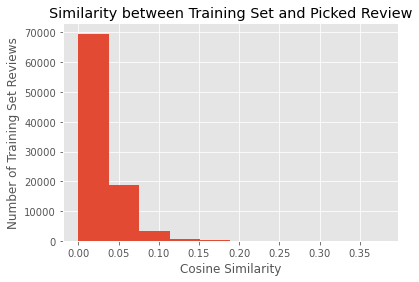

In [13]:
# Calculate the similarity score(s) between vector(s) and training vectors
similarity = cosine_similarity(X_train, review)
similarity = similarity.reshape(len(similarity),)

# Cosine similarity ranges from abs(0, 1)
# But even the top values are rather close to 0 ... Expect mediocre results
plt.title("Similarity between Training Set and Picked Review")
plt.ylabel("Number of Training Set Reviews")
plt.xlabel("Cosine Similarity")
plt.hist(similarity)

In [14]:
# Let's find top 4 similar reviews
top_similar_reviews = get_top_values(lst=similarity, n=4, labels=reviews_train.values)

In [15]:
# Print search results!
# At the very least, the top search result is somewhat relevant to the input query
# They both discuss an evening meal, and share the same concerns of cold food

print('Our search query:')
print(reviews_test.iloc[review_ind]) 
print()

print('Most %s similar reviews:' % len(top_similar_reviews))
for i, review in enumerate(top_similar_reviews):
    print("___ Review {} ___".format(i+1))
    print(review)
    print("___END___\n")

Our search query:
Amazing food, incredible service. I love everyone who works here and kind of come just to see them sometimes.  Veggy Street is a simple, delicious spot for a quick vegan bite. Def recommend

Most 4 similar reviews:
___ Review 1 ___
Wow!!!!!!! My Veggy Cheeseburger was mouth watering good. I was craving a burger but didn't really want one, and I am so happy I came to Veggy Street!!!!!!! Well Done Veggy Street!!!!!!!!

Yum!!!!!!!!!!!!!!!!

*Employees*
Thanks Max for the amazing customer service. He was super helpful and offered amazing menu suggestions. He told me that the Veggy cheeseburger is one of the best items on the menu. I must say I was very pleased with my Veggy cheeseburger and fries. 

I will definitely be returning for more delicious food!!!!! 

*Inside* 
The inside is super clean with cute decor and their logo on the wall. Check out was super quick and easy. There is a giant menu up front but more detailed menus are available as well. 

P.S- you get a deli

* Q: Do the results make sense?

* A: It seems we are lucky with the particular review picked. All the top similar reviews discuss Indian restaurants
and their curries; two of them also discussed the taste of the chicken served. Cannot guarantee globally acceptable performance, but don't have better (and simple) ideas now.

## Classifying positive/negative review

1. Build **logistic regression** classifier first, because its coefficients are the easiest to interpret. That would help us understand the language used in the reviews better.
2. Then, build multinomial **naive Bayes** (NB) classifier. Given how training and running a NB model is very quick, if it performs reasonably well it may just serve as the production model!

Accuracy, precision and recall metrics recorded for held-out test data, courtesy of `sklearn.metrics.classification_report`

### Logistic Regression Classifier

In [16]:
lr_clf = LogisticRegression(solver="lbfgs", max_iter=200)
lr_clf.fit(X_train, target_train)

# Get accuracy for training set
print(lr_clf.score(X_train, target_train))

# Get accuracy for test set.
# Not bad! Let's hope RandomForest can beat LR; if not, LR works pretty well already
print(lr_clf.score(X_test, target_test))

0.867177632644249
0.8428256833196598


#### Q: Which features (words) tend to produce a positive/negative prediction?

Glad to see that features with the most positive/negative coefficients in logistic regression actually correspond to positive/negative sentiments! (Remember, perfect = 1, imperfect = 0) 

In [17]:
# Must first create a mapping from feature index to actual word
ix_to_words = {ix:word for word,ix in vocab.items()}

top_positive_words = get_top_values(lst=lr_clf.coef_[0], n=10, labels=ix_to_words)
print(top_positive_words)

top_negative_words = get_bottom_values(lst=lr_clf.coef_[0], n=10, labels=ix_to_words)
print(top_negative_words)

['amazing', 'best', 'awesome', 'delicious', 'excellent', 'thank', 'highly', 'incredible', 'fantastic', 'perfect']
['worst', 'ok', 'horrible', 'rude', 'disappointing', 'okay', 'terrible', 'not', 'slow', 'mediocre']


In [18]:
""" Accuracy/Precision/Recall all similarly high, good """
print(classification_report(target_test, lr_clf.predict(X_test), target_names=("Negative", "Positive")))

              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85     12277
    Positive       0.83      0.84      0.83     10882

    accuracy                           0.84     23159
   macro avg       0.84      0.84      0.84     23159
weighted avg       0.84      0.84      0.84     23159



#### (Multinomial) Naive Bayes Classifier
Technically multinomial naive Bayes should be fed integer features, but according to [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) fractional tf-idf values work in practice, too. 

In [19]:
# Default settings of Laplace smoothing, and computing class priors from data
nb_clf = MultinomialNB(alpha=1.0, fit_prior=True)
nb_clf.fit(X_train, target_train)

# Get accuracy for training set
print(nb_clf.score(X_train, target_train))

# Get accuracy for test set.
# Not bad! If this accuracy is accceptable, definitely should consider deploying NB model
# It's quick to run and can be updated online
print(nb_clf.score(X_test, target_test))

0.836811140497652
0.8170041884364609


In [20]:
""" Perfect reviews have weaker recall; maybe that's where naive Bayes lost out to logistic regression """
print(classification_report(target_test, nb_clf.predict(X_test), target_names=("Negative", "Positive")))

              precision    recall  f1-score   support

    Negative       0.82      0.84      0.83     12277
    Positive       0.82      0.79      0.80     10882

    accuracy                           0.82     23159
   macro avg       0.82      0.82      0.82     23159
weighted avg       0.82      0.82      0.82     23159



### What about non-linear models?

Can we obtain even better classification performance with non-linear models, such as random forest? Unfortunately, my laptop takes hours to cross validate random forest --- and sometimes the program still doesn't terminate.

With a better computer, I would cut down on the number of features using PCA, and then feed the principal components to a downstream, non-linear model. That should keep computations manageable.

### What can we do with the models?

How can we make use of the sentiment analysis models trained above? Admittedly, for Yelp  reviews, it doesn't seem necessary to predict a label for each review, because each review is already associated with a star rating. (In fact, that's how we got our labels.)

However, one can imagine wanting to classify text reviews coming from outside Yelp; in this case, the enormous Yelp data set is great for building a baseline model.

Then, for instance, given a corpus of unlabeled reviews for e.g. new restaurants, the models allow us to quickly estimate e.g. the proportion of positive/negative reviews. Demonstrated below using Yelp data.

In [21]:
# Reload to keep things clean
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv',
                 dtype={tag: np.int16 for tag in ("useful", "funny", "cool")})

df = df.drop(columns=["attributes"])

most_reviewed_restaurants = df.groupby("business_id")\
                              ["review_id"].nunique()\
                                           .sort_values(ascending=False)

In [22]:
pos_rev_df = []

for bid in most_reviewed_restaurants.index[0:5]:
    # For each business_id (bid)
    # predict sentiment of associated reviews
    # then compute the predicted proportion of +ve reviews
    df_bid = df.query("`business_id` == @bid")
    
    reviews_bid = vectorizer.transform(df_bid["text"])
    predicted_sentiments = lr_clf.predict(reviews_bid)
    positive_review_proportion = (predicted_sentiments == True).sum() / predicted_sentiments.shape[0]
    
    restaurant_name = df_bid["name"].iloc[0]
    pos_rev_df.append((restaurant_name, positive_review_proportion))
    
pos_rev_df = pd.DataFrame(pos_rev_df, columns=["Restaurant", "Proportion of Positive Reviews"])\
               .set_index("Restaurant")

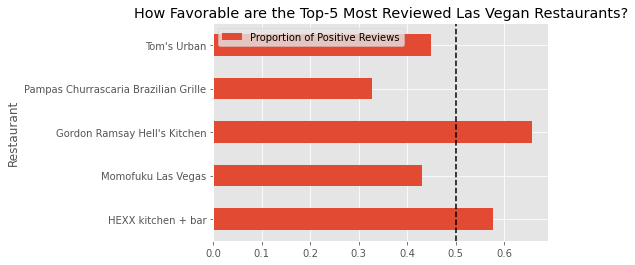

In [24]:
# For the most-reviewed restaurant, Tom's Urban, number of reviews with negative sentiment
# outnumbers positive ones!

pos_rev_df.plot.barh(title="How Favorable are the Top-5 Most Reviewed Las Vegan Restaurants?")
plt.axvline(0.5, ls="--", color="black")

## Summary of Steps Taken + Results

### Obtained vector representation of text reviews
Tf-idf vectors, with only basic filtering of stop words.

### Basic search engine for "similar" reviews
Given a query in text; searches corpus and return the most similar reviews. Cosine similarity is used here, because it is insentive; therefore the search engine can still function alright, even when the query is much shorter or longer than corpus documents.

### Sentiment analysis
Both logistic regression and multinomial naive Bayes easily achieved over 80% of accuracy, on both training and test sets. While logistic regression performs 3-4% better, if prediction speed or training time is really an issue, naive Bayes is definitely a viable alternative.

On the other hand, at least for the present amount of data, tuning random forest takes too long for the performance gain obtained. It easily overfits on the training data, and after elaborate, randomized hyperparameter search it only achieves the same accuracy as naive Bayes! Not worth exploring unless with a more powerful computer.